In [1]:
# import packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import idx2numpy
import os
import pickle
from PIL import Image

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [2]:
# Define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Define a methor to load cifar10
def load_batch(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    X = data[b'data']
    Y = data[b'labels']
    X = X.reshape(-1, 3, 32, 32)
    X = X.astype('float32') / 255.0
    Y = np.array(Y)
    return X, Y

In [10]:
# Load the training set
X_train = []
y_train = []
for i in range(1, 6):
    filename = '../datasets/cifar-10-batches-py/data_batch_' + str(i)
    X, y = load_batch(filename)
    X_train.append(X)
    y_train.append(y)
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Load the test set
X_test, y_test = load_batch('../datasets/cifar-10-batches-py/test_batch')

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 3, 32, 32) (50000,) (10000, 3, 32, 32) (10000,)


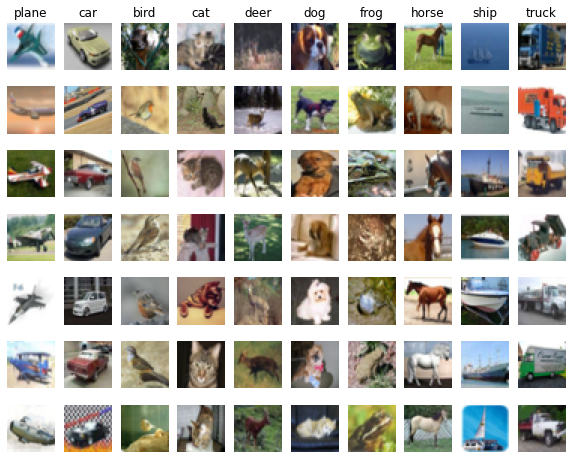

In [12]:
# We show a few examples of training images from each class.
plt.rcParams['figure.figsize'] = (10.0, 8.0)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 7

def visualize_data(dataset, classes, samples_per_class):
    num_classes = len(classes)
    for y, cls in enumerate(classes):
      idxs = np.flatnonzero(y_train == y)
      idxs = np.random.choice(idxs, samples_per_class, replace=False)
      for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(dataset[idx])
        plt.axis('off')
        if i == 0:
          plt.title(cls)
    plt.show()

visualize_data(X_train.transpose(0, 2, 3, 1), classes, samples_per_class)

In [97]:
# Define the rotation function
def img_rotate(img, deg=1):
    img1 = np.transpose(img, (1, 2, 0))
    img1 = np.rot90(img1, deg)
    return np.transpose(img1, (2, 0, 1))

In [98]:
# Expand X_train and y_train
X_train_all = []
y_train_all = []

for (x, y) in zip(X_train, y_train):
    X_train_all.append(x)
    X_train_all.append(img_rotate(x))
    X_train_all.append(img_rotate(x, 2))
    X_train_all.append(img_rotate(x, 3))

    for i in range(4):
        y_train_all.append((y, i))


In [104]:
X_train_all = torch.Tensor(np.array(X_train_all, dtype=np.float32))
y_train_all = torch.Tensor(np.array(y_train_all, dtype=np.int64))

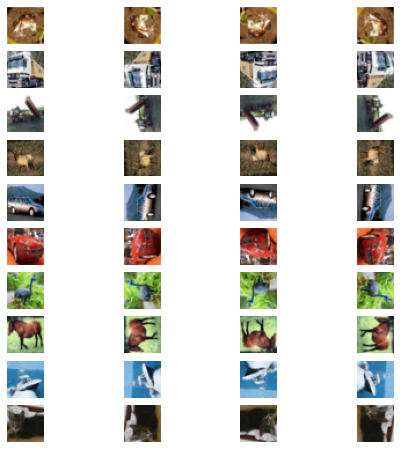

tensor([[6., 0.],
        [6., 1.],
        [6., 2.],
        [6., 3.],
        [9., 0.],
        [9., 1.],
        [9., 2.],
        [9., 3.],
        [9., 0.],
        [9., 1.],
        [9., 2.],
        [9., 3.],
        [4., 0.],
        [4., 1.],
        [4., 2.],
        [4., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [2., 0.],
        [2., 1.],
        [2., 2.],
        [2., 3.],
        [7., 0.],
        [7., 1.],
        [7., 2.],
        [7., 3.],
        [8., 0.],
        [8., 1.],
        [8., 2.],
        [8., 3.],
        [3., 0.],
        [3., 1.],
        [3., 2.],
        [3., 3.]])


In [106]:
# Display 40 images from X_train_all
fig, axs = plt.subplots(10, 4, figsize=(8, 8))
for i in range(10):
    for j in range(4):
        axs[i, j].imshow(np.transpose(X_train_all[i*4+j], (1, 2, 0)))
        axs[i, j].axis("off")
plt.show()
print(y_train_all[:40])

In [107]:
class JointCNN(nn.Module):
    def __init__(self):
        super(JointCNN, self).__init__()
        # Shared layers - theta E
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Branch 1 - theta M
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

        # Branch 2 - theta S
        self.fc3 = nn.Linear(64 * 8 * 8, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x1 = torch.relu(self.bn1(self.fc1(x)))
        x1 = self.fc2(x1)
        x1 = F.log_softmax(x1, dim=1)
        x2 = torch.relu(self.bn2(self.fc3(x)))
        x2 = self.fc4(x2)
        x2 = F.log_softmax(x2, dim=1)
        return x1, x2
    

# Define my dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [123]:
# Set up the data loaders
train_loader = torch.utils.data.DataLoader(MyDataset(X_train_all, y_train_all), batch_size=100, shuffle=True)

# Define the loss functions
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()


# Initialize the model and define optimizer
model = JointCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [124]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Linear-5                  [-1, 128]         524,416
       BatchNorm1d-6                  [-1, 128]             256
            Linear-7                   [-1, 10]           1,290
            Linear-8                  [-1, 128]         524,416
       BatchNorm1d-9                  [-1, 128]             256
           Linear-10                    [-1, 4]             516
Total params: 1,070,542
Trainable params: 1,070,542
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.47
Params size (MB): 4.08
Estimat

In [126]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        labels_1 = labels[:,0].to(torch.int64)
        labels_2 = labels[:,1].to(torch.int64)
        images, labels_1, labels_2 = images.to(device), labels_1.to(device), labels_2.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        out1, out2 = model(images)

        # Compute the loss
        loss1 = criterion1(out1, labels_1)
        loss2 = criterion2(out2, labels_2)
        loss = loss1 + loss2

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [100/2000], Loss: 1.2115
Epoch [1/10], Step [200/2000], Loss: 1.2786
Epoch [1/10], Step [300/2000], Loss: 1.2969
Epoch [1/10], Step [400/2000], Loss: 1.4148
Epoch [1/10], Step [500/2000], Loss: 1.3486
Epoch [1/10], Step [600/2000], Loss: 1.0276
Epoch [1/10], Step [700/2000], Loss: 1.3391
Epoch [1/10], Step [800/2000], Loss: 1.0870
Epoch [1/10], Step [900/2000], Loss: 1.3101
Epoch [1/10], Step [1000/2000], Loss: 0.9762
Epoch [1/10], Step [1100/2000], Loss: 1.1839
Epoch [1/10], Step [1200/2000], Loss: 1.3337
Epoch [1/10], Step [1300/2000], Loss: 1.4148
Epoch [1/10], Step [1400/2000], Loss: 1.0892
Epoch [1/10], Step [1500/2000], Loss: 1.1922
Epoch [1/10], Step [1600/2000], Loss: 1.2263
Epoch [1/10], Step [1700/2000], Loss: 1.0021
Epoch [1/10], Step [1800/2000], Loss: 1.0862
Epoch [1/10], Step [1900/2000], Loss: 1.2047
Epoch [1/10], Step [2000/2000], Loss: 1.6281
Epoch [2/10], Step [100/2000], Loss: 0.9820
Epoch [2/10], Step [200/2000], Loss: 1.1791
Epoch [2/10], Step [3

Epoch [10/10], Step [500/2000], Loss: 0.5171
Epoch [10/10], Step [600/2000], Loss: 0.4393
Epoch [10/10], Step [700/2000], Loss: 0.5660
Epoch [10/10], Step [800/2000], Loss: 0.5430
Epoch [10/10], Step [900/2000], Loss: 0.4424
Epoch [10/10], Step [1000/2000], Loss: 0.4336
Epoch [10/10], Step [1100/2000], Loss: 0.6852
Epoch [10/10], Step [1200/2000], Loss: 0.5658
Epoch [10/10], Step [1300/2000], Loss: 0.4609
Epoch [10/10], Step [1400/2000], Loss: 0.5337
Epoch [10/10], Step [1500/2000], Loss: 0.4977
Epoch [10/10], Step [1600/2000], Loss: 0.6966
Epoch [10/10], Step [1700/2000], Loss: 0.6489
Epoch [10/10], Step [1800/2000], Loss: 0.5097
Epoch [10/10], Step [1900/2000], Loss: 0.5909
Epoch [10/10], Step [2000/2000], Loss: 0.5945


In [127]:
# Expand X_test and y_test
X_test_all = []
y_test_all = []

for (x, y) in zip(X_test, y_test):
    X_test_all.append(x)
    X_test_all.append(img_rotate(x))
    X_test_all.append(img_rotate(x, 2))
    X_test_all.append(img_rotate(x, 3))

    for i in range(4):
        y_test_all.append((y, i))

        
X_test_all = torch.Tensor(np.array(X_test_all, dtype=np.float32))
y_test_all = torch.Tensor(np.array(y_test_all, dtype=np.int64))

In [132]:
test_loader = torch.utils.data.DataLoader(MyDataset(X_test_all, y_test_all), batch_size=1000, shuffle=True)

# Compute the accuracy on the test set
correct1 = 0
correct2 = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        labels_1 = labels[:,0].to(torch.int64)
        labels_2 = labels[:,1].to(torch.int64)
        images, labels_1, labels_2 = images.to(device), labels_1.to(device), labels_2.to(device)

        # Forward pass
        out1, out2 = model(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct1 += (predicted == labels_1).sum().item()
        _, predicted = torch.max(out2.data, 1)
        correct2 += (predicted == labels_2).sum().item()
        total += labels_2.size(0)

print('Accuracy for image classification: {:.2f}'.format(100 * correct1 / total))
print('Accuracy for rotation classification:{:.2f}'.format(100 * correct2 / total))

Accuracy for image classification: 68.31
Accuracy for rotation classification:77.21
